# Tissue dielectric calculation results
*Author: Dr Vitas Anderson*

This notebook examines the results of the first and second trials to calculate the tissue dielectric values, $\epsilon_r$ and $\sigma$, for the homogeneous TARO phantom.

In the first trial (run 1), mass weighted values of $\epsilon_r$ and $\sigma$ were used as the  starting guesses.

In the second trial (runs 2, 3 & 4), the starting guess for the $\epsilon_r$ and $\sigma$ values were based on Hurt's 2/3 muscle estimates, with further iterative modifications after that.

**Run 1**: Used mass weighted values of $\epsilon_r$ and $\sigma$ as starting guesses. Then added four extra ($\epsilon_r$, $\sigma$) coordinate pairs with two points further up the mass weighted dielectric curve and and two further down.

**Run 2**: Used Hurt's 2/3 muscle estimates as the starting first guess values. This point was surrounded in a 5x5 rectangular grid of ($\epsilon_r$, $\sigma$) coordinate pairs spaced as 0.6, 0.8, 1, 1.2, 1.4x the best estimate.

**Run 3**: Used Hurt's 1/2 muscle estimates as the starting first guess values. This point was surrounded in a 5x5 rectangular grid of ($\epsilon_r$, $\sigma$) coordinate pairs spaced as 0.6, 0.8, 1, 1.2, 1.4x the best estimate.

**Run 4**: Selected the best estimate by reviewing contour plots of $\epsilon_r$, $\sigma$ vs SARratio. This point was surrounded in a 5x5 rectangular grid of ($\epsilon_r$, $\sigma$) coordinate pairs spaced as 0.4, 0.7, 1, 1.3, 1.6x the best estimate.

**Run 5**: SEP phantom results for best ($\epsilon_r$ and $\sigma$) coordinate pairs

<u>REFERENCES</u>

TARO intercomparison WBA SAR data was obtained from:</br>
<font color='blue'>Dimbylow, P. J., Hirata, A., & Nagaoka, T. (2008). **Intercomparison of whole-body averaged SAR in European and Japanese voxel phantoms**. Physics in Medicine and Biology, 53(20), 5883–5897.</font>

Calculate tissue dielectric values using the Gabriel formulas published in:</br>
<font color='blue'>Gabriel, S. Lau, R.W. & Gabriel, C. (1996) **"The dielectric properties of biological tissues: III.
Parametric models for the dielectric spectrum of tissues"**, *Phys. Med. Biol.* 41 (1996) 2271–2293</font>

Tissue mass proportions were obtained from:</br>
<font color='blue'>Tahara, Y., Moji, K., Aoyagi, K., Tsunawake, N., Muraki, S., & Mascie-Taylor, C. G. N. (2002). **Age-related pattern of body density and body composition of Japanese men and women 18-59 years of age**. *American Journal of Human Biology*, 14(6).</font>

## Setup

In [48]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sn
from icecream import ic
pd.set_option('display.max_rows', 100)

## Functions

In [83]:
def loadSAR(taroSAR, FEKO_SEP_file, run):
    '''Creates a dataframe of the WBA SAR data from the FEKO SEP model 
       merged on frequency with the WBA SAR data for the TARO phantom
       in the Dimbylow study
       INPUTS:
         taroSAR = dataframe of TARO SAR data
         FEKO_SEP_file = file path for the SEP phantom WBA SAR data
         run = trial number of the data
       OUTPUT:
         dfSAR is a datframe of the merged TARO and SEP phantom data'''
    
    sepSAR = pd.read_csv(FEKO_SEP_file)
    if 'alpha' in sepSAR.columns:
        sepSAR = sepSAR.drop(columns='alpha')
    sepSAR.columns = ['fMHz','er','sigma','P','SARsep']
    sepSAR.SARsep = sepSAR.SARsep * 1E6  # convert SARsep to µW/kg

    dfSAR = sepSAR.merge(taroSAR,on='fMHz')
    dfSAR['SARratio'] = dfSAR.SARsep / dfSAR.SARtaro
    dfSAR['run'] = str(run)
    return dfSAR

def contourSAR(dfSAR, top=0.985):
    '''Generate contour plot of R for a single run
       Assumes that for each frequency (fMHz) the er/sigma coordinates of 
       the data is arranged in a regular 5x5 mesh 
       INPUTS:
         dfSAR = dataframe containing the data (fMHz, er, sigma, SARratio)
         top = top proportion for rect variable in the tight_layout figure function'''
    
    nf = len(dfSAR.fMHz.unique())
    nrows = int(np.ceil(nf/2))
    figsize = (8, 3.6*nrows)
    fig, axes = plt.subplots(nrows,2,figsize=figsize)
    axes = axes.flatten()
    levels = [0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4]
    run = dfSAR.loc[0,'run']
    ixlev1 = levels.index(1)
    coords = []

    for i, (fMHz, g) in enumerate(dfSAR.groupby('fMHz')):
        # draw contour plot for each fMHz
        er = g.er.values.reshape(5,5)
        sigma = g.sigma.values.reshape(5,5)
        SARratio = g.SARratio.values.reshape(5,5)
        CS = axes[i].contour(er,sigma,SARratio,levels=levels,
                             linewidths=0.5,colors='black')
        axes[i].clabel(CS, inline=True, fontsize=9)
        cntr2 = axes[i].contourf(er,sigma,SARratio,levels=levels,
                    cmap="RdBu_r")
        fig.colorbar(cntr2, ax=axes[i])
        axes[i].plot(er,sigma,'ro',ms=3,alpha=0.5)
        axes[i].set(xlabel=r'$\epsilon_r$',ylabel=r'$\sigma$ (S/m)')

        # Calculate and print the [er,sigma] coordinates for the R=1 contour
        coord = [[run,fMHz]+c for path in CS.collections[ixlev1].get_paths() for c in path.vertices.tolist()]
        coords = coords + coord
        coorddf = pd.DataFrame(coord, columns=['run','fMHz','er','sigma']).sort_values(['er','sigma'])

        # Plot those R=1 coordinate points
        axes[i].plot(coorddf.er,coorddf.sigma,'bo',markersize=3)

        # list the R=1 coordinates in the title
        coordpairs = ''
        for ix, c in coorddf.iterrows():
            coordpairs += f'({round(c.er,1)},{round(c.sigma,3)}) '
            if (ix+1) % 3 == 0:
                coordpairs += '\n'
        title = f'{fMHz:g} MHz\n' + coordpairs
        axes[i].set_title(title, fontsize=8, color='blue')        

    fig.suptitle(r'ratio of $\frac{SAR_{homogeneous}}{SAR_{heterogeneous}}$ for run ' + f'{run}',
                 color='green', fontsize=16)
    fig.tight_layout(rect=(0,0,1,top))
    coordsdf = pd.DataFrame(coords, columns=['run','fMHz','er','sigma']).sort_values(['fMHz','er','sigma'])
    
    return fig, coordsdf

def tricontourSAR(dfSAR):
    nf = len(dfSAR.fMHz.unique())
    nrows = int(np.ceil(nf/2))
    figsize = (8, 3.6*nrows)
    fig, axes = plt.subplots(nrows,2,figsize=figsize)
    axes = axes.flatten()
    levels = [0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4]
    ixlev1 = levels.index(1)
    coords = []

    for i, (fMHz, g) in enumerate(dfSAR.groupby('fMHz')):
        # draw contour plot for each fMHz
        ax = axes[i]
        CS = ax.tricontour(g.er,g.sigma,g.SARratio,levels=levels,
                           linewidths=0.5, colors='k')
        cntr2 = ax.tricontourf(g.er,g.sigma,g.SARratio,levels=levels,
                               cmap="RdBu_r")
        fig.colorbar(cntr2, ax=ax)
        ax.plot(g.er, g.sigma, 'ko', ms=3)
        ax.set_title(f'{fMHz:g} MHz')
        ax.set(xlabel=r'$\epsilon_r$',ylabel=r'$\sigma$ (S/m)')

        # Calculate and print the er/sigma coordinates for R=1
        coord = [[fMHz]+c for path in CS.collections[ixlev1].get_paths() for c in path.vertices.tolist()]
        coords = coords + coord
        coorddf = pd.DataFrame(coord, columns=['fMHz','er','sigma']).sort_values('er').reset_index()

        # Plot those R=1 coordinate points
        axes[i].plot(coorddf.er,coorddf.sigma,'bo',markersize=3)

        # list the R=1 coordinates in the title
        coordpairs = ''
        for ix, c in coorddf.iterrows():
            coordpairs += f'({round(c.er,1)},{round(c.sigma,3)}) '
            if (ix+1) % 3 == 0:
                coordpairs += '\n'
        title = f'{fMHz:g} MHz\n' + coordpairs
        ax.set_title(title, fontsize=8, color='blue')        

    runs = ', '.join(np.sort(dfSAR.run.unique()))
    title = r'ratio of $\frac{SAR_{sep}}{SAR_{taro}}$ for runs ' + runs
    fig.suptitle(title, color='green', fontsize=16)
    fig.tight_layout(rect=(0,0,1,0.98))
    coordsdf = pd.DataFrame(coords, columns=['fMHz','er','sigma'])

    return fig, coordsdf

def Rplots(dfSAR, title):
    fig, [ax1,ax2] = plt.subplots(2,1,figsize=(8,9))
    plt.suptitle(title, color='blue',fontsize=15)

    # top plot
    dfSAR.plot(x='fMHz',y='SARsep',kind='scatter',color="none", edgecolor="blue",s=40,
               ax=ax1,label='SEP phantom')
    dfSAR.plot(x='fMHz',y='SARtaro',kind='scatter',color='r',
               ax=ax1, label='TARO phantom')
    ax1.set_ylim([10,200])
    ax1.set_xlim([10,10_000])
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.set_xlabel('Frequency (MHz)')
    ax1.set_ylabel('SAR (µW/kg)')
    ax1.legend()
    ax1.grid(True, which='both',ls='--')

    # bottom plot
    dfSAR.plot(x='fMHz',y='SARratio',kind='scatter',color="none", 
               edgecolor="green",s=40, ax=ax2)
    ax2.axhline(y=1, color='r', linestyle='--')
    ax2.set_ylim([0.6,1.4])
    ax2.set_xlim([10,10_000])
    ax2.set_xscale('log')
    ax2.set_ylabel(r'$\frac{SAR_{SEP}}{SAR_{TARO}}$', fontsize=20)
    ax2.set_xlabel('Frequency (MHz)')
    ax2.grid(True, which='both',ls='--')
    fig.tight_layout(rect=(0,0,1,0.98))
    return fig

def ersig1(cdf, title=''):
    '''This function creates two side by side plots for [er,sigma] coordinates
       where SARratio = 1:
         fMHz v er plot
         fMHz v sigma plot
       Points can be multi selected in either plot and will be similarly
       marked in the other plot
       INPUTS:
         cdf = dataframe of R=1 [fMHz, er, sigma] records'''

    brush = alt.selection_multi()
    chart = alt.Chart(cdf).mark_point().encode(
        x=alt.X('fMHz:Q',scale=alt.Scale(zero=False,type="log",domain=[30, 3000])),
        y='er:Q',
        color=alt.condition(brush,'run:N',alt.value('lightgray')),
        tooltip=['fMHz:Q','er:Q','sigma:Q']
    ).add_selection(
        brush
    ).properties(
        width=450,
        height=400,
        title=title
    )

    return chart | chart.encode(y='sigma:Q')

def ersig2(dfSAR, title=''):
    chart = alt.Chart(dfSAR).mark_circle(
    ).encode(
        alt.X(alt.repeat("row"), type='quantitative', scale=alt.Scale(zero=False,type='log')),
        alt.Y(alt.repeat("column"), type='quantitative', scale=alt.Scale(zero=False)),
        # alt.X('fMHz:Q',scale=alt.Scale(zero=False,type="log")),
        # alt.Y('er:Q',scale=alt.Scale(zero=False)),
        color=alt.Color('SARratio', scale=alt.Scale(scheme='blueorange'),
                        bin=alt.Bin(maxbins=11)),
        tooltip=['fMHz','er','sigma','SARratio']
    ).properties(
        width=450,
        height=400,
    ).repeat(
        row=['fMHz'],
        column=['er', 'sigma']
    ).properties(
        title=title,
    )
    
    return chart

## Load TARO WBA SAR values
from the Dimbylow interlab comparison study

In [50]:
taro_file = "./data/TARO and HANAKO intercomparison data.xlsx"
taroSAR = pd.read_excel(taro_file, 'TARO',usecols=['MHz','HPA'])
taroSAR.rename(columns={'MHz':'fMHz','HPA':'SARtaro'},inplace=True)
taroSAR.head()

fMHz  SARtaro
0    30    15.96
1    40    32.20
2    50    56.93
3    60    82.78
4    65    89.44

## Load SEP phantom WBA SAR values
Load data for 4 FEKO runs of Danie's SEP homogeneous phantom. 

Note that runs 2a and 2b have been combined into a single run 2 where the run 2b rounding errors in $\epsilon_r$ and $\sigma$ have been fixed

In [51]:
# Load run 1 data
SEP_file = './data/run1_human-phantom-height1.72-vol6.07353E-2.csv'
dfSAR1 = loadSAR(taroSAR, SEP_file, '1')

# Load run 2 data
SEP_file = './data/run2_human-phantom-height1.72m-combined 2a and 2b.csv'
dfSAR2 = loadSAR(taroSAR, SEP_file, '2')

# Load run 3 data
SEP_file = './data/run3_human-phantom-height1.72m 0.5muscle.csv'
dfSAR3 = loadSAR(taroSAR, SEP_file, '3')

# Load run 4 data
SEP_file = './data/run4_results_human-phantom-height1.72m.csv'
dfSAR4 = loadSAR(taroSAR, SEP_file, '4')

# Combine runs 1, 2, 3 and 4
dfSAR12   = pd.concat([dfSAR1,dfSAR2]).sort_values(['fMHz','er','sigma'])
dfSAR23   = pd.concat([dfSAR2,dfSAR3]).sort_values(['fMHz','er','sigma'])
dfSAR123  = pd.concat([dfSAR1,dfSAR2,dfSAR3]).sort_values(['fMHz','er','sigma'])
dfSAR234  = pd.concat([dfSAR2,dfSAR3,dfSAR4]).sort_values(['fMHz','er','sigma'])
dfSAR1234 = pd.concat([dfSAR1,dfSAR2,dfSAR3,dfSAR4]).sort_values(['fMHz','er','sigma'])

# Load run 5 data
SEP_file = './data/run5_results_human-phantom-height1.72m.csv'
dfSAR5 = loadSAR(taroSAR, SEP_file, '5')

## Run 2
2/3 muscle tissue dielectric values

In [52]:
dfSAR2.head()

fMHz       er   sigma         P  SARsep  SARtaro  SARratio run
0    30  36.7241  0.2632  0.001300    21.4    15.96  1.340852   2
1    30  36.7241  0.3509  0.001160    19.1    15.96  1.196742   2
2    30  36.7241  0.4387  0.001030    16.9    15.96  1.058897   2
3    30  36.7241  0.5264  0.000915    15.1    15.96  0.946115   2
4    30  36.7241  0.6142  0.000823    13.6    15.96  0.852130   2

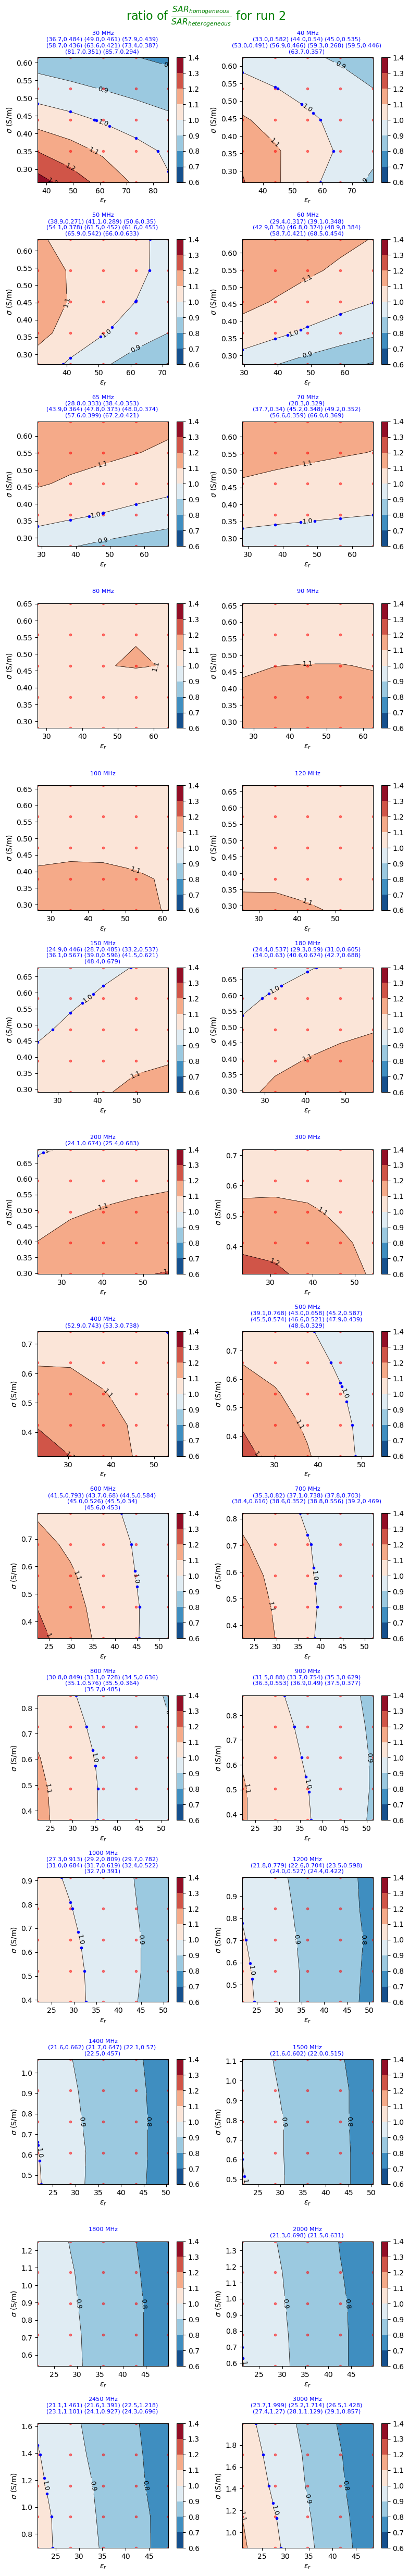

In [86]:
fig2, coordsdf2 = contourSAR(dfSAR2, top=0.985)
fig2.savefig('../plots/ratio contour run2.png',dpi=200)

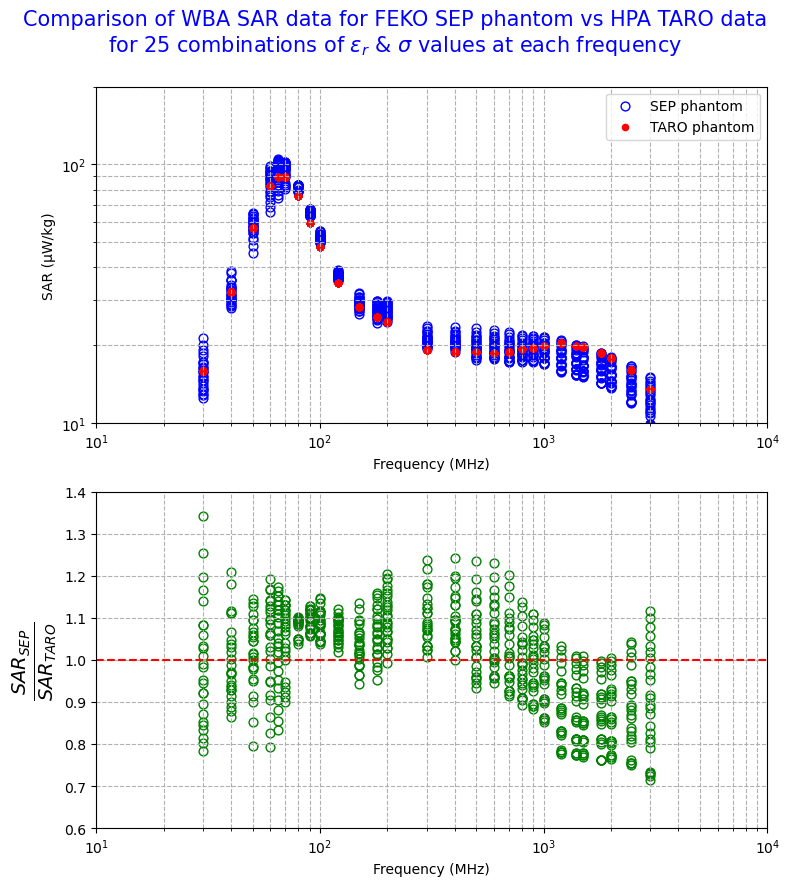

In [54]:
title = 'Comparison of WBA SAR data for FEKO SEP phantom vs HPA TARO data\nfor 25 combinations of $\epsilon_r$ & $\sigma$ values at each frequency'
fig = Rplots(dfSAR2,title)

In [55]:
ersig1(coordsdf2, title='Second run')

alt.HConcatChart(...)

In [56]:
ersig2(dfSAR2, title='Second run')

alt.RepeatChart(...)

In [57]:
alt.Chart(dfSAR2).mark_circle(
).encode(
    alt.X(alt.repeat("column"), type='quantitative', scale=alt.Scale(zero=False,type='log')),
    alt.Y(alt.repeat("row"), type='quantitative', scale=alt.Scale(zero=False)),
    color=alt.Color('fMHz', scale=alt.Scale(scheme='viridis')),
    tooltip=['fMHz','er','sigma']
).properties(
    width=400,
    height=300,
).repeat(
    row=['SARratio'],
    column=['er', 'sigma']
).properties(
    title="ScatterMatrix for first 2/3 muscle trial"
) #.interactive()

alt.RepeatChart(...)

## Runs 1 & 2
Combines data from the first run with data from run 2

In [58]:
dfSAR12.head()

fMHz       er   sigma         P  SARsep  SARtaro  SARratio run
0  30.0  36.7241  0.2632  0.001300    21.4    15.96  1.340852   2
1  30.0  36.7241  0.3509  0.001160    19.1    15.96  1.196742   2
2  30.0  36.7241  0.4387  0.001030    16.9    15.96  1.058897   2
3  30.0  36.7241  0.5264  0.000915    15.1    15.96  0.946115   2
4  30.0  36.7241  0.6142  0.000823    13.6    15.96  0.852130   2

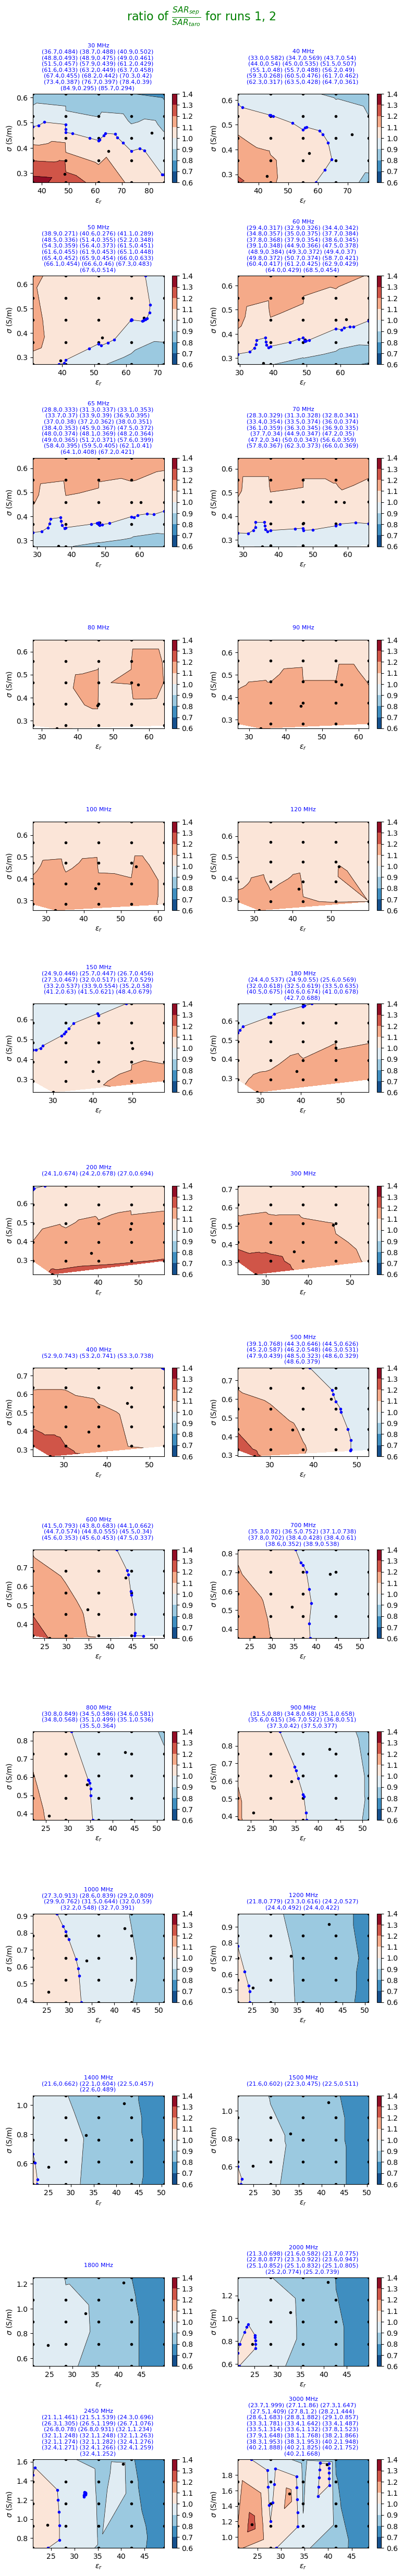

In [59]:
fig12, coordsdf12 = tricontourSAR(dfSAR12)

<p style="color:red;">The combination of runs 1 & 2 seems to cause strange conflicts between the two as shown by the jagged contours. This seems to point to some simulation discrepancy between the two runs, the cause of which is currently unknown.</p>

**In that case, do not use the data from run 1**

## Run 3
1/2 muscle tissue dielectric values

In [60]:
dfSAR3.head()

fMHz       er   sigma         P  SARsep  SARtaro  SARratio run
0    80  20.6305  0.2093  0.004407    72.6    75.58  0.960572   3
1    80  20.6305  0.2791  0.004730    77.9    75.58  1.030696   3
2    80  20.6305  0.3488  0.004893    80.6    75.58  1.066420   3
3    80  20.6305  0.4186  0.004968    81.8    75.58  1.082297   3
4    80  20.6305  0.4884  0.004995    82.2    75.58  1.087589   3

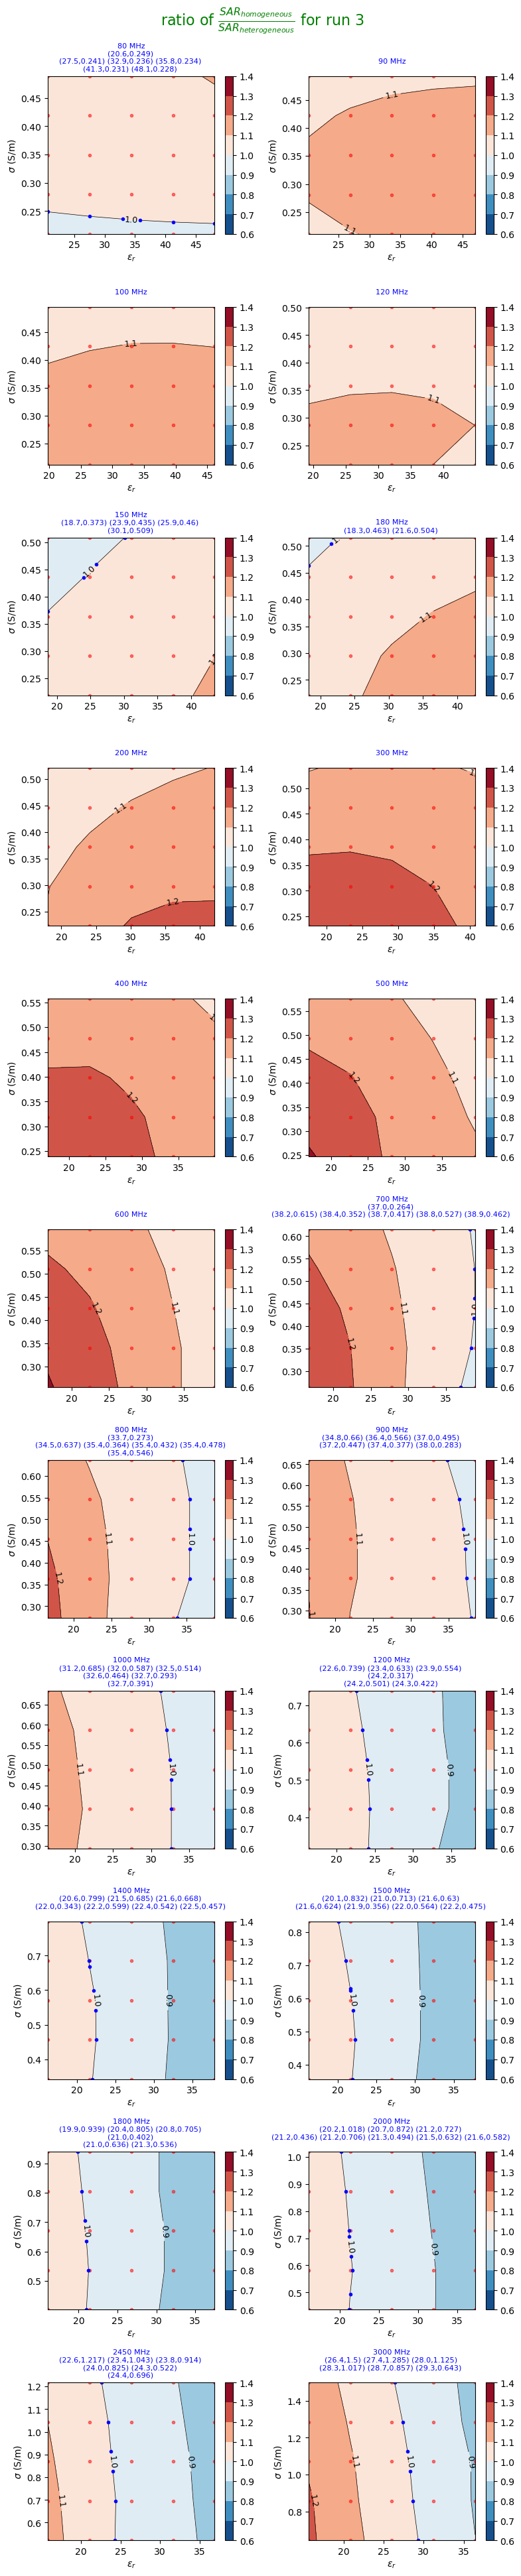

In [61]:
fig3, coordsdf3 = contourSAR(dfSAR3)

In [87]:
fig3.savefig('../plots/ratio contour run3.png',dpi=200)

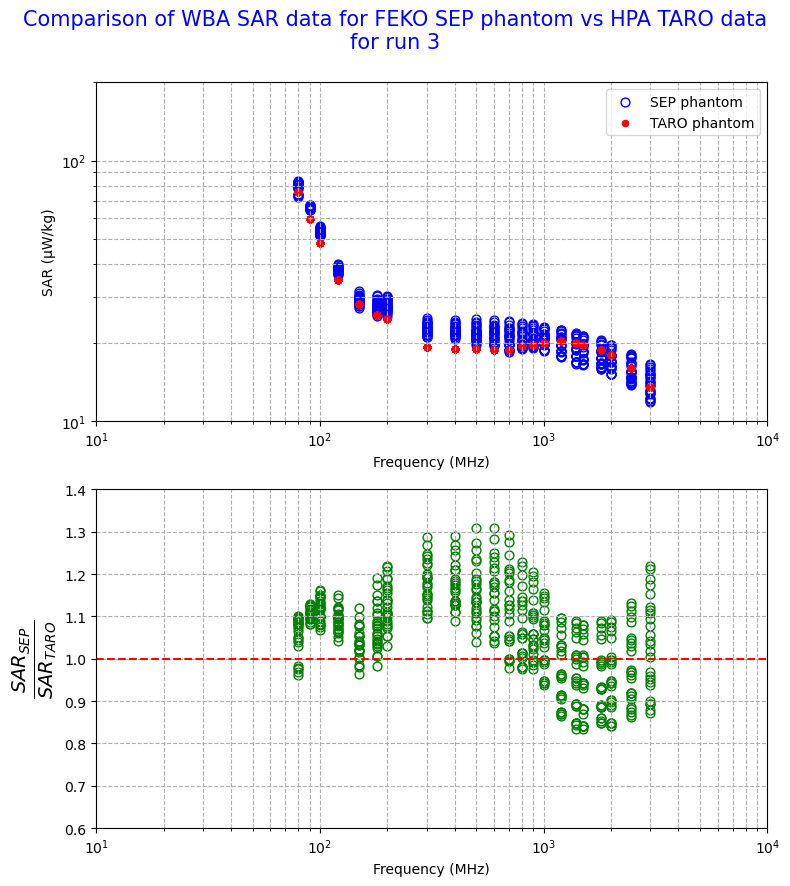

In [62]:
title = 'Comparison of WBA SAR data for FEKO SEP phantom vs HPA TARO data\nfor run 3'
fig = Rplots(dfSAR3,title)

In [63]:
ersig1(coordsdf3, title='Run 3')

alt.HConcatChart(...)

In [64]:
ersig2(dfSAR3, title='Run 3')

alt.RepeatChart(...)

In [65]:
alt.Chart(dfSAR3).mark_circle(
).encode(
    alt.X(alt.repeat("column"), type='quantitative', scale=alt.Scale(zero=False,type='log')),
    alt.Y(alt.repeat("row"), type='quantitative', scale=alt.Scale(zero=False)),
    color=alt.Color('fMHz', scale=alt.Scale(scheme='viridis')),
    tooltip=['fMHz','er','sigma']
).properties(
    width=400,
    height=300,
).repeat(
    row=['SARratio'],
    column=['er', 'sigma']
).properties(
    title="ScatterMatrix for first 2/3 muscle trial"
) #.interactive()

alt.RepeatChart(...)

## Runs 2 & 3
combined run 2b (2/3 muscle) and run 3 (0.5 muscle tissue)

In [66]:
dfSAR23.head()

fMHz       er   sigma         P  SARsep  SARtaro  SARratio run
0    30  36.7241  0.2632  0.001300    21.4    15.96  1.340852   2
1    30  36.7241  0.3509  0.001160    19.1    15.96  1.196742   2
2    30  36.7241  0.4387  0.001030    16.9    15.96  1.058897   2
3    30  36.7241  0.5264  0.000915    15.1    15.96  0.946115   2
4    30  36.7241  0.6142  0.000823    13.6    15.96  0.852130   2

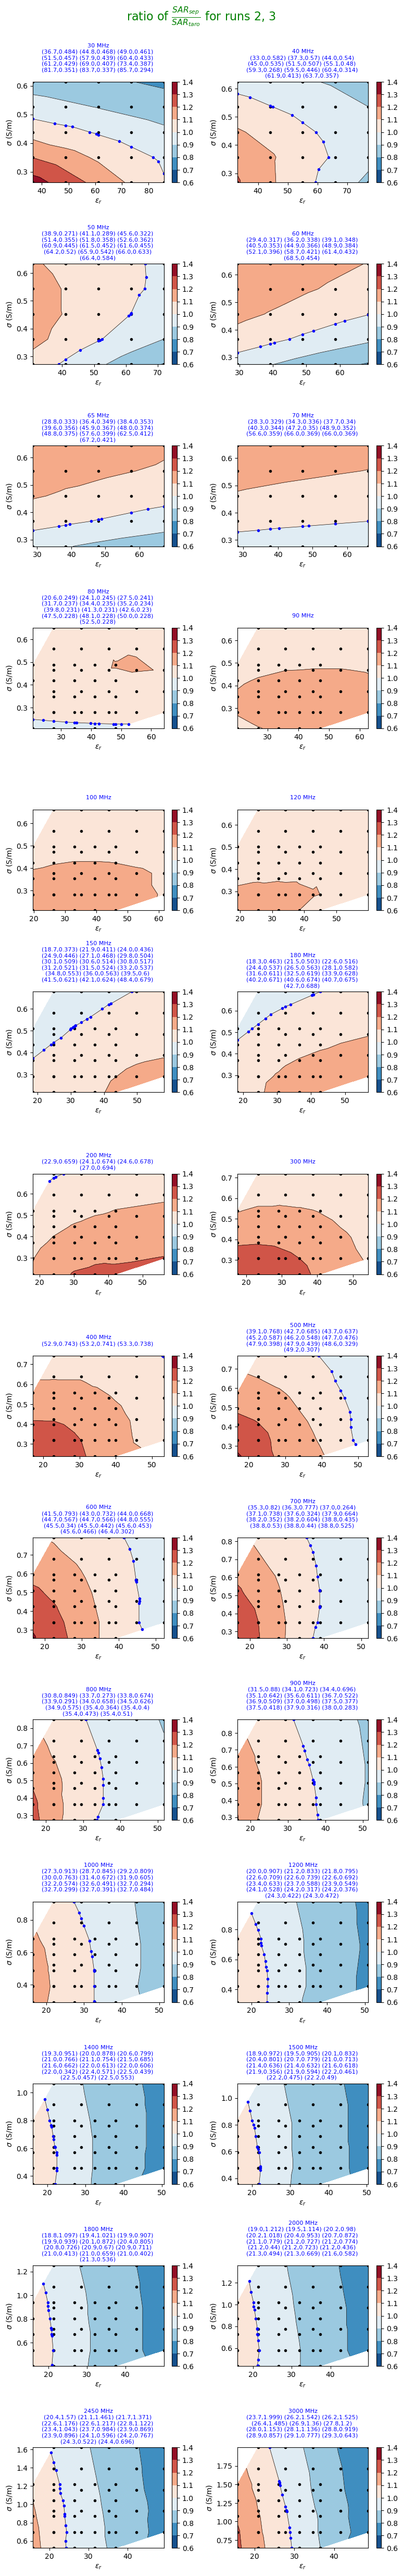

In [67]:
fig23, coordsdf23 = tricontourSAR(dfSAR23)

## Run 4
Pick ($\epsilon_r, \sigma$) coordinate grids from looking at contour plots from previous runs

In [68]:
dfSAR4.head()

fMHz    er  sigma         P  SARsep  SARtaro  SARratio run
0    30  32.0   0.12  0.001358  22.356    15.96  1.400752   4
1    30  32.0   0.21  0.001413  23.266    15.96  1.457769   4
2    30  32.0   0.30  0.001270  20.905    15.96  1.309837   4
3    30  32.0   0.39  0.001114  18.341    15.96  1.149185   4
4    30  32.0   0.48  0.000981  16.158    15.96  1.012406   4

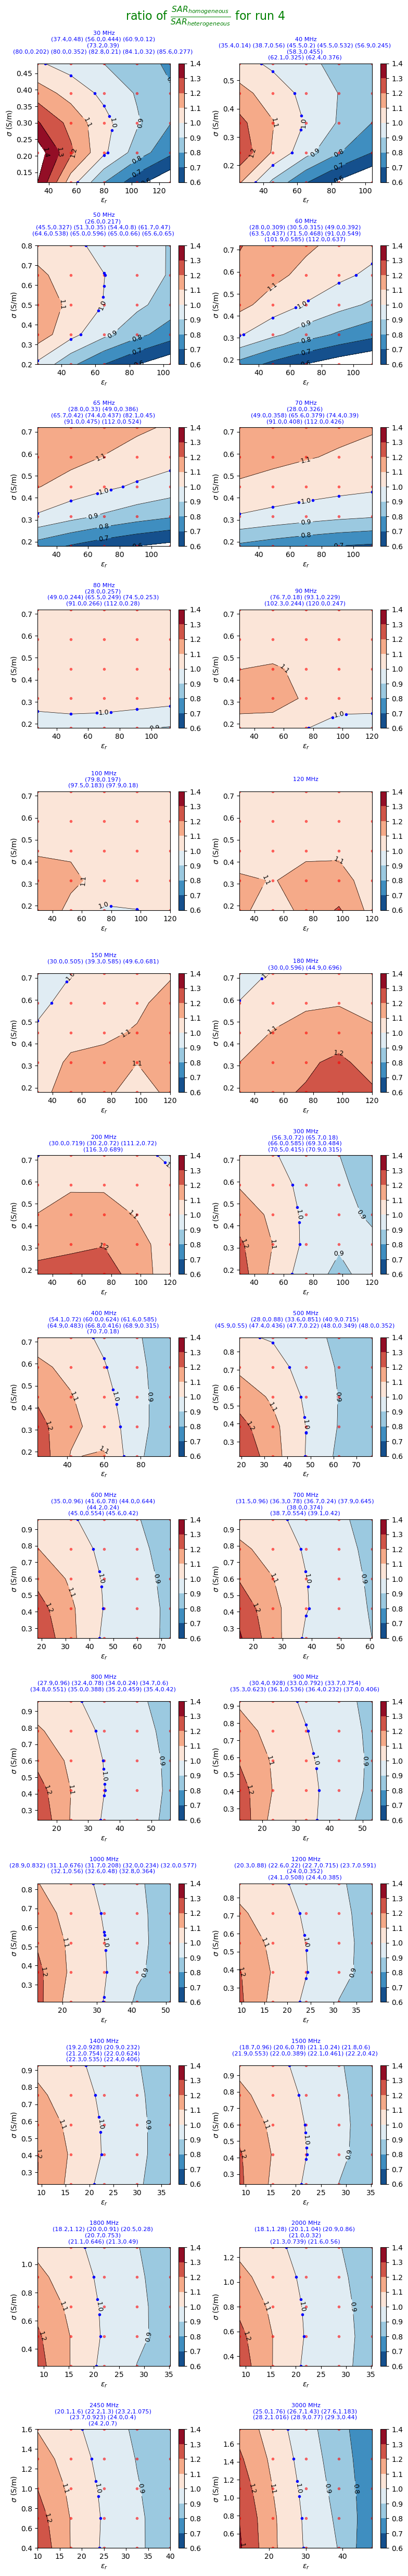

In [88]:
fig4, coordsdf4 = contourSAR(dfSAR4)

In [89]:
fig4.savefig('../plots/ratio contour run4.png',dpi=200)

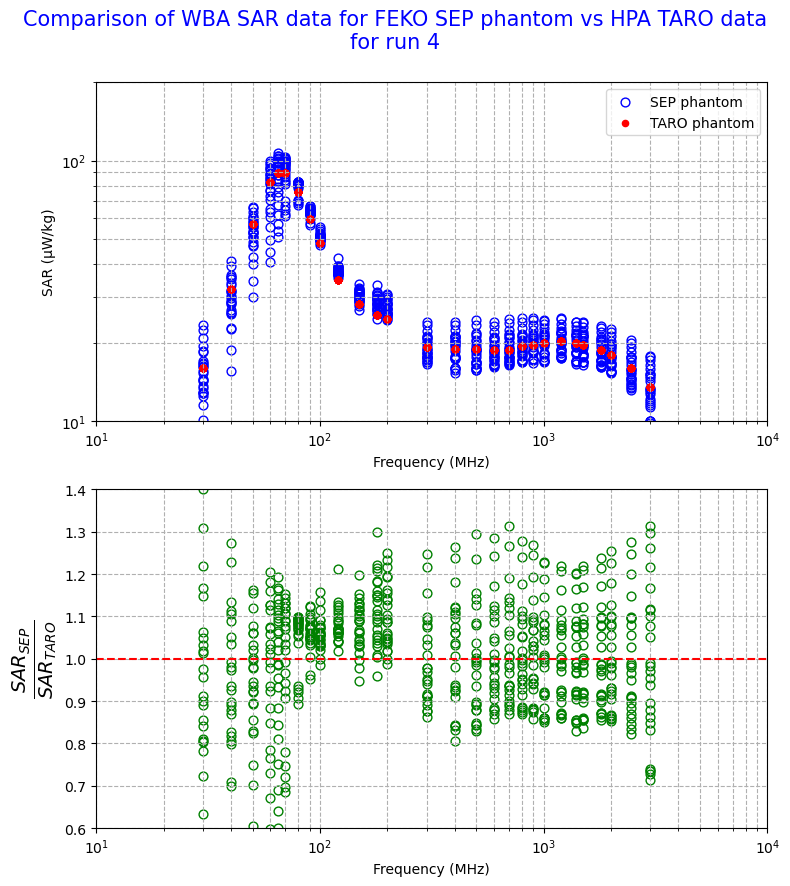

In [70]:
title = 'Comparison of WBA SAR data for FEKO SEP phantom vs HPA TARO data\nfor run 4'
fig4 = Rplots(dfSAR4,title)

In [71]:
ersig1(coordsdf4, title='Run 4')

alt.HConcatChart(...)

In [72]:
ersig2(dfSAR4, title='Run 4')

alt.RepeatChart(...)

## Runs 2, 3 & 4
Combine runs 2, 3 & 4

In [73]:
dfSAR234.head()

fMHz    er  sigma         P  SARsep  SARtaro  SARratio run
0    30  32.0   0.12  0.001358  22.356    15.96  1.400752   4
1    30  32.0   0.21  0.001413  23.266    15.96  1.457769   4
2    30  32.0   0.30  0.001270  20.905    15.96  1.309837   4
3    30  32.0   0.39  0.001114  18.341    15.96  1.149185   4
4    30  32.0   0.48  0.000981  16.158    15.96  1.012406   4

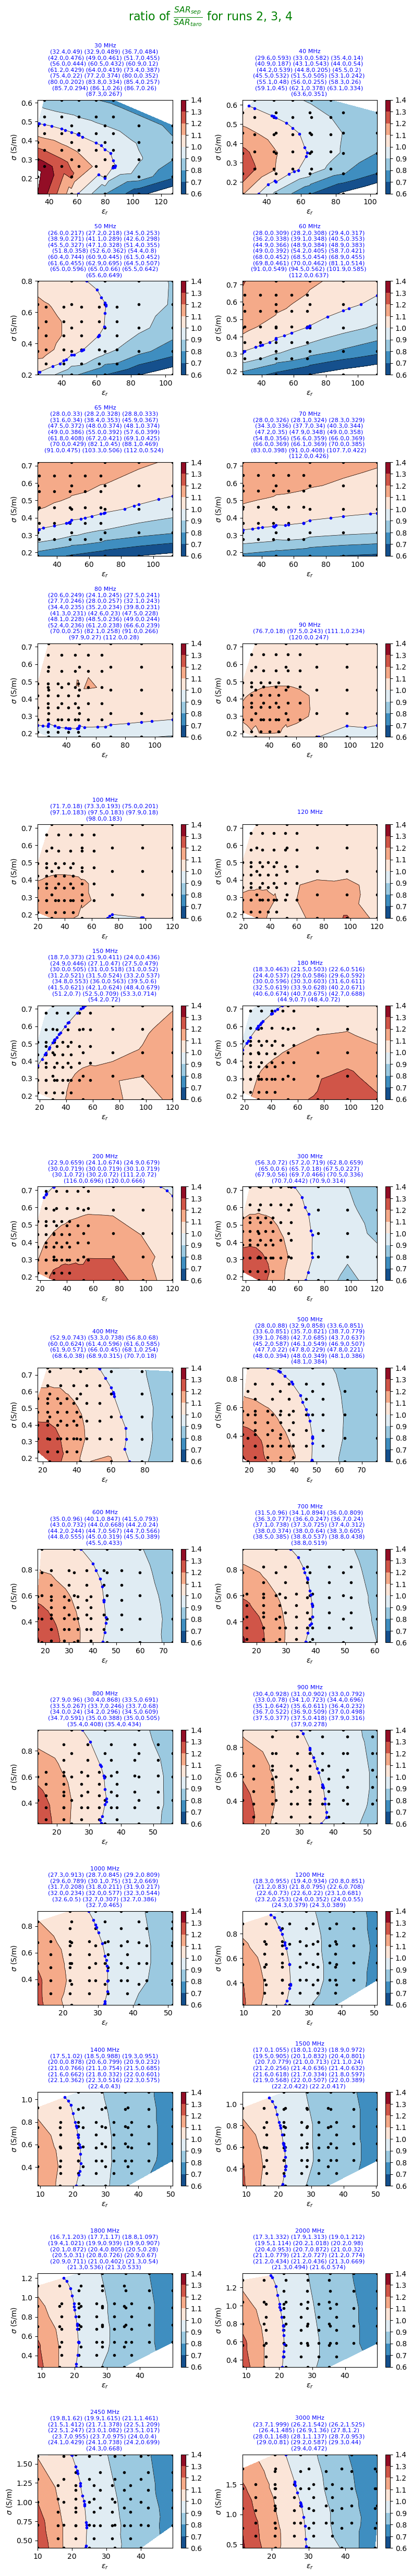

In [91]:
fig234, coordsdf234 = tricontourSAR(dfSAR234)

In [92]:
fig234.savefig('../plots/ratio contour run234.png',dpi=200)

In [75]:
coordsdf234 = coordsdf234.sort_values(['fMHz','er','sigma'])
coordsdf234.to_clipboard();

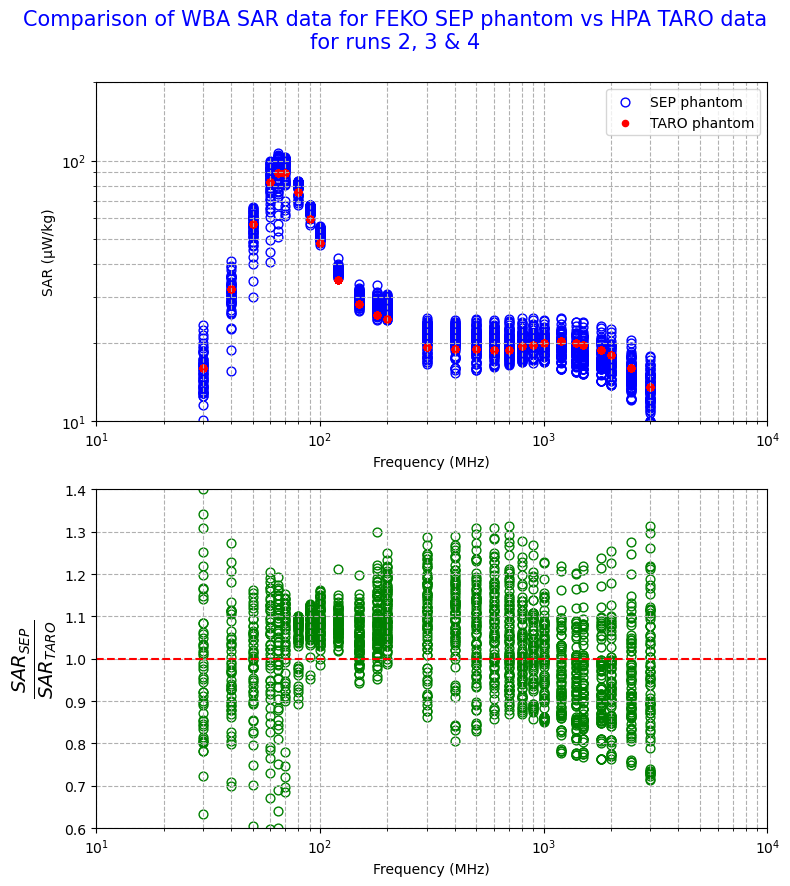

In [76]:
title = 'Comparison of WBA SAR data for FEKO SEP phantom vs HPA TARO data\nfor runs 2, 3 & 4'
fig234 = Rplots(dfSAR234,title)

In [77]:
ersig1(coordsdf234, title='Runs 2,3,4')

alt.HConcatChart(...)

In [78]:
ersig2(dfSAR234, title='Runs 2,3,4')

alt.RepeatChart(...)

## $(\epsilon_r, \sigma)$ coordinate pair selection
The data in the `coordsdf234` dataframe (ie. R=1 pairs for runs 2,3,4) was copied to an excel file `Best er sigma pairs.xlsx` where the best $(\epsilon_r, \sigma)$ pairs were chosen on the criterion of producing reasonably smooth $\epsilon_r$ and $\sigma$ line plots

### Load $(\epsilon_r, \sigma)$ coordinate pairs from excel spreadsheet

In [42]:
xlfile = './data/Best er sigma pairs.xlsx'
best_coords = pd.read_excel(xlfile, 'find coord pairs',skiprows=2,
                            usecols=('A,C,F')).dropna().reset_index(drop=True)
best_coords.to_clipboard()

### Plot best $(\epsilon_r, \sigma)$ coordinate pairs

In [43]:
base = alt.Chart(coordsdf234).mark_point().encode(
    x=alt.X('fMHz:Q',scale=alt.Scale(type='log',domain=[30,3000])),
    y='er:Q'
).properties(
    width=500,
    height=400
)

coords = alt.Chart(best_coords).mark_point(
    color='red'
).encode(
    x='fMHz:Q',
    y='erp:Q'
)

base + coords + coords.mark_line(color='red')

alt.LayerChart(...)

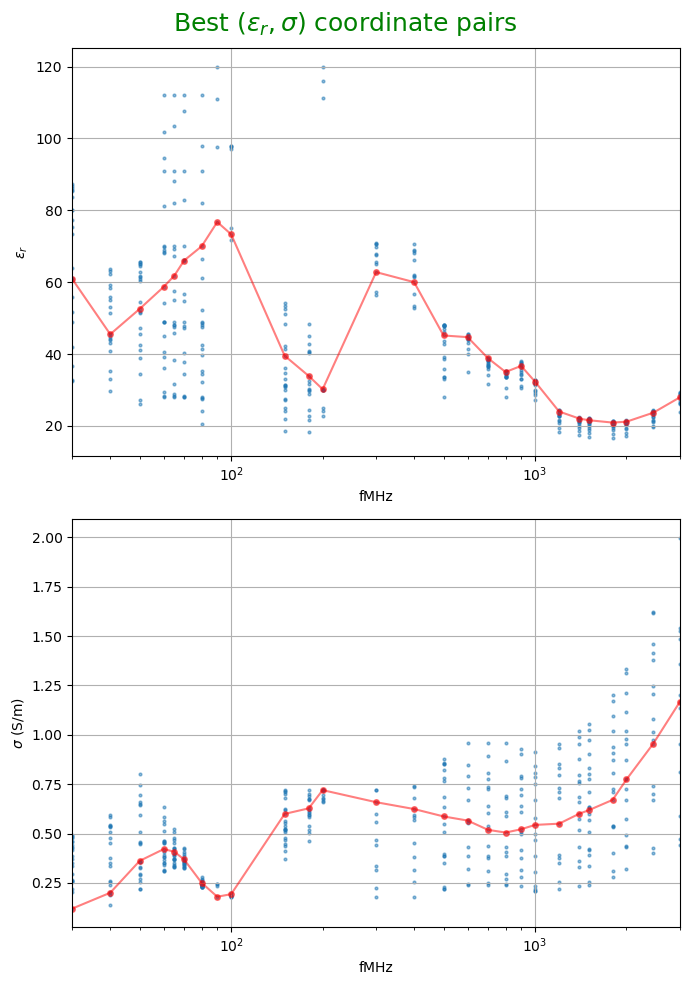

In [94]:
fig, axes = plt.subplots(2,1,figsize=(7,10))
axes = axes.flatten()

axes[0].scatter(coordsdf234.fMHz,coordsdf234.er,s=4,alpha=0.5)
axes[0].plot(best_coords.fMHz,best_coords.erp,'o-',
             color='red',markersize=4,alpha=0.5)
axes[0].set_xscale('log')
axes[0].grid()
axes[0].set_xlim(30,3000)
axes[0].set_xlabel('fMHz')
axes[0].set_ylabel(r'$\epsilon_r$')

axes[1].scatter(coordsdf234.fMHz,coordsdf234.sigma,s=4,alpha=0.5)
axes[1].plot(best_coords.fMHz,best_coords.sigmap,'o-',
             color='red',markersize=4,alpha=0.5)
axes[1].set_xscale('log')
axes[1].grid()
axes[1].set_xlim(30,3000)
axes[1].set_xlabel('fMHz')
axes[1].set_ylabel(r'$\sigma$ (S/m)')

fig.suptitle(r'Best $(\epsilon_r, \sigma)$ coordinate pairs',
             fontsize=18, color='green')
fig.tight_layout()

fig.savefig('../plots/best er sigma pairs.png',dpi=200)

## Run 5
These are the SEP phantom results for the best $(\epsilon_r, \sigma)$ coordinate pairs

### Check SEP phantom results for best coordinate pairs

In [98]:
dfSAR5[['fMHz','er','sigma','SARratio']].set_index('fMHz')

er   sigma  SARratio
fMHz                         
30    60.85  0.1200  0.992607
40    45.50  0.2001  1.034752
50    52.56  0.3616  0.999930
60    58.71  0.4213  1.004035
65    61.81  0.4079  1.002762
70    66.01  0.3688  1.000448
80    70.00  0.2499  1.022612
90    76.73  0.1800  0.998391
100   73.32  0.1929  1.007233
150   39.52  0.5995  0.999431
180   33.89  0.6277  1.000429
200   30.20  0.7200  1.000162
300   62.79  0.6588  0.997714
400   60.00  0.6242  1.000106
500   45.16  0.5867  0.999894
600   44.70  0.5658  1.001871
700   38.84  0.5189  1.000159
800   35.00  0.5051  1.001550
900   36.69  0.5218  0.999898
1000  32.31  0.5437  0.999849
1200  24.00  0.5500  1.000000
1400  22.02  0.6008  1.000702
1500  21.59  0.6178  1.000815
1800  20.92  0.6705  1.001387
2000  21.16  0.7740  1.000167
2450  23.67  0.9555  0.999126
3000  27.97  1.1683  0.997489

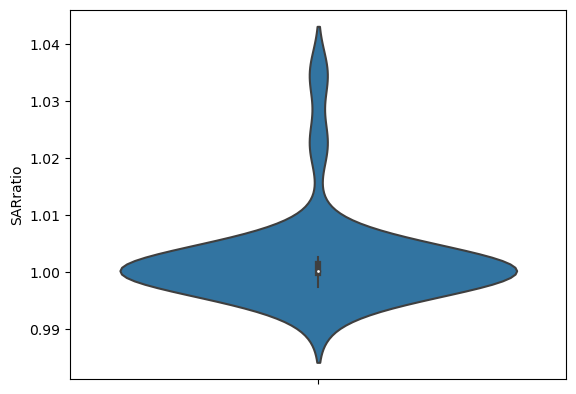

In [101]:
sn.violinplot(y=dfSAR5["SARratio"]);

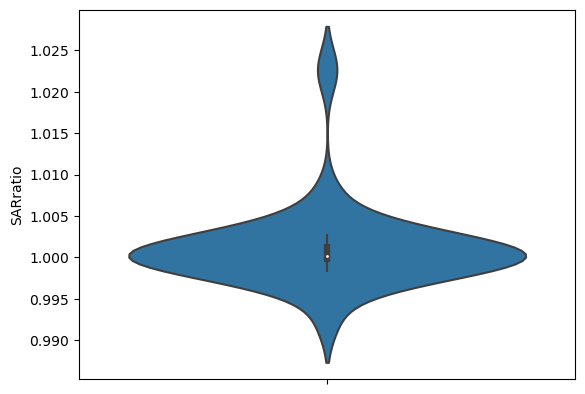

In [102]:
mask = dfSAR5.SARratio < 1.03
sn.violinplot(y=dfSAR5.loc[mask,'SARratio']);

## Scratch

In [44]:
dfSAR5.loc[mask,'SARratio']

0     0.992607
2     0.999930
3     1.004035
4     1.002762
5     1.000448
6     1.022612
7     0.998391
8     1.007233
9     0.999431
10    1.000429
11    1.000162
12    0.997714
13    1.000106
14    0.999894
15    1.001871
16    1.000159
17    1.001550
18    0.999898
19    0.999849
20    1.000000
21    1.000702
22    1.000815
23    1.001387
24    1.000167
25    0.999126
26    0.997489
Name: SARratio, dtype: float64